In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
train_df = pd.read_csv("train.csv", parse_dates=['fecha'])

# train.csv

* **id** - 254099, **Entero**
* **titulo** - "condominio horizontal...", **string**
* **descripcion** - "lo que sea", **String**
* **tipoDePropiedad** - Apartamento-Casa en condominio, **debería ser tipo en enum**
* **direccion** - "av. mexico", **String**
* **ciudad** - "Benito Juarez", **String**
* **provincia** - "Distrito Federal", **String**
* **antiguedad** - 10.0, Años **Decimal**
* **habitaciones** - 2.0, **Decimal**
* **garages** -  1.0, **Decimal**
* **idZona** - 23533.0, **Decimal**
* **lat** - 19.310205, **muchos numeros después de la coma**
* **ing** - -99.227655, **esto es la long**
* **fecha** - 2015-08-23 00:00:00, es un **datetime**
* **gimnasio** - 1.0 o 0.0, **verdadero o falso**
* **usosMultiples** - 1.0 o 0.0, **verdadero o falso**
* **piscina** - 1.0 o 0.0, **verdadero o falso**
* **escuelasCercanas** - 1.0 o 0.0, **verdadero o falso**
* **precio** - 2273000.0, en pesos Mexicanos

In [2]:
train_df.dtypes

id                                     int64
titulo                                object
descripcion                           object
tipodepropiedad                       object
direccion                             object
ciudad                                object
provincia                             object
antiguedad                           float64
habitaciones                         float64
garages                              float64
banos                                float64
metroscubiertos                      float64
metrostotales                        float64
idzona                               float64
lat                                  float64
lng                                  float64
fecha                         datetime64[ns]
gimnasio                             float64
usosmultiples                        float64
piscina                              float64
escuelascercanas                     float64
centroscomercialescercanos           float64
precio    

# ---------------------------------------------

Voy a filtrar todo lo que no sea una **Casa**

In [3]:
casas = train_df.loc[train_df["tipodepropiedad"] == "Casa"]

Voy a ver si encuentro algun atributo donde haya cantidades parejas, y ver si hay alguna diferencia notable en los precios

## ----------------------------------------------------------------------------------------------

## BoxPlot de precios para casas 
### Voy a probar filtrando y agrupando por las distintas caracteristicas

* ### Piscina (Supongo que es inutil, por la diferencia de cantidades)

In [4]:
casaPrecioPiscina = casas.iloc[:, [19,22]]
casaPrecioPiscina.head()

,piscina,precio
2,0.00,1200000.00
3,0.00,650000.00
6,0.00,1150000.00
7,0.00,4200000.00
10,0.00,488000.00


In [5]:
casasConPiscinaCount = casaPrecioPiscina.groupby(casaPrecioPiscina["piscina"]).agg({"count"}).reset_index()
casasConPiscinaCount.columns = ["TienePiscina", "Cantidad"]
casasConPiscinaCount.plot.bar(x="TienePiscina", y="Cantidad", rot=0, title = "Cantidad de casas con/sin piscina",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Text(0, 0.5, 'Cantidad')

Text(0.5, 1.0, 'Precios de casas con y sin piscina')

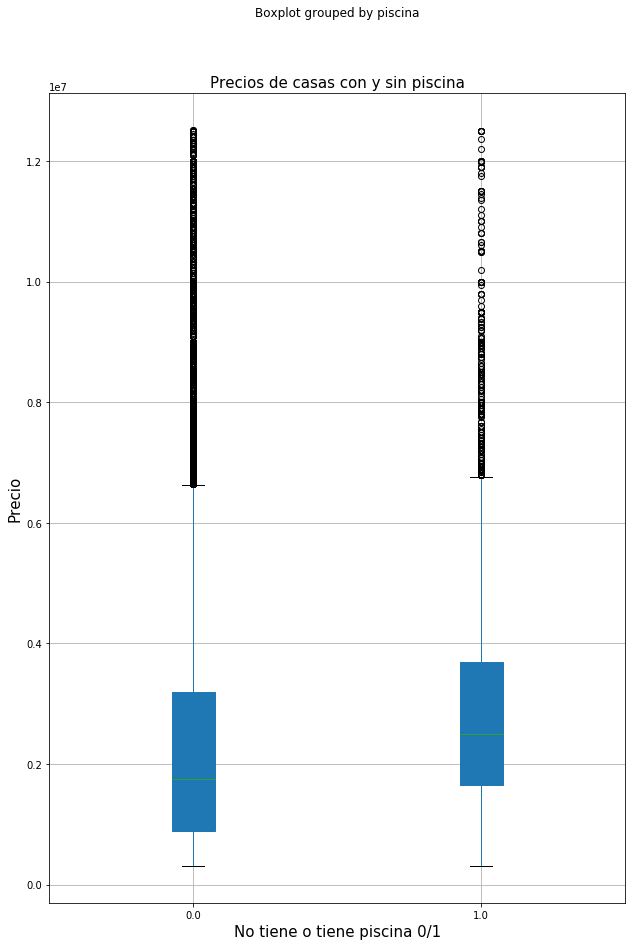

In [6]:
casaPrecioPiscinaBoxPlot = casaPrecioPiscina.boxplot(column=["precio"],patch_artist=True, figsize=(10,15), by=["piscina"])
casaPrecioPiscinaBoxPlot.set_xlabel("No tiene o tiene piscina 0/1", fontsize=15)
casaPrecioPiscinaBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioPiscinaBoxPlot.set_title("Precios de casas con y sin piscina", fontsize=15)

Aunque haga un boxplot, la diferencia de cantidad de casas para un grupo y otro es muy grande, creo que no es comparable

* ### Escuelas cercanas (Inutil, cantidades parecidas, pero los precios son casi iguales)

In [7]:
casaPrecioEscuela = casas.iloc[:, [20,22]]
casaPrecioEscuela.head()

,escuelascercanas,precio
2,0.00,1200000.00
3,1.00,650000.00
6,0.00,1150000.00
7,0.00,4200000.00
10,1.00,488000.00


Text(0, 0.5, 'Cantidad')

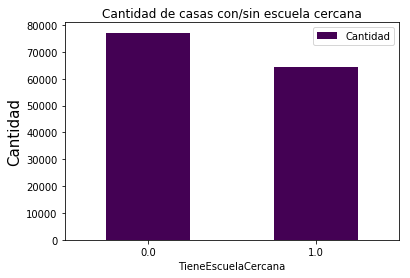

In [8]:
casasConEscuelaCercaCount = casaPrecioEscuela.groupby(casaPrecioEscuela["escuelascercanas"]).agg({"count"}).reset_index()
casasConEscuelaCercaCount.columns = ["TieneEscuelaCercana", "Cantidad"]
casasConEscuelaCercaCount.plot.bar(x="TieneEscuelaCercana", y="Cantidad", rot=0, title = "Cantidad de casas con/sin escuela cercana",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Las cantidades son mucho más parecidas

Text(0.5, 1.0, 'Precios de casas con y sin escuelas cercanas')

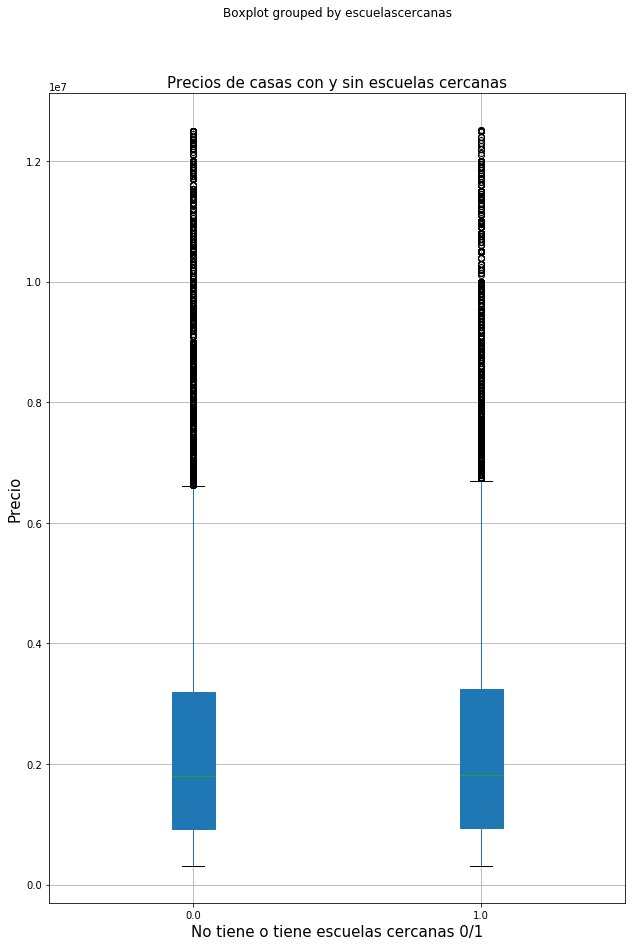

In [9]:
casaPrecioEscuelaBoxPlot = casaPrecioEscuela.boxplot(column=["precio"],patch_artist=True, figsize=(10,15), by=["escuelascercanas"])
casaPrecioEscuelaBoxPlot.set_xlabel("No tiene o tiene escuelas cercanas 0/1", fontsize=15)
casaPrecioEscuelaBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioEscuelaBoxPlot.set_title("Precios de casas con y sin escuelas cercanas", fontsize=15)

Si supuse que el anterior era inútil...

* ### Gimnasio (Inutil como el primero)

In [10]:
casaPrecioGimnasio = casas.iloc[:, [17,22]]
casaPrecioGimnasio.head()

,gimnasio,precio
2,0.00,1200000.00
3,0.00,650000.00
6,0.00,1150000.00
7,0.00,4200000.00
10,0.00,488000.00


Text(0, 0.5, 'Cantidad')

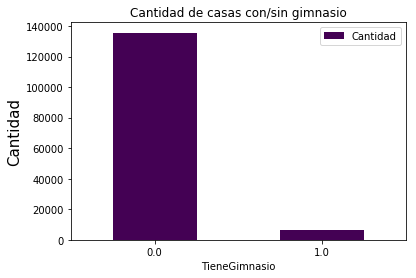

In [11]:
casasConGimnasioCount = casaPrecioGimnasio.groupby(casaPrecioGimnasio["gimnasio"]).agg({"count"}).reset_index()
casasConGimnasioCount.columns = ["TieneGimnasio", "Cantidad"]
casasConGimnasioCount.plot.bar(x="TieneGimnasio", y="Cantidad", rot=0, title = "Cantidad de casas con/sin gimnasio",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Era obvio igual que iba a pasar esto...

* ### Usos multiples (Ni lo hago porque esto es más de edificio)

## Precio de casas por ciudad 
### Voy a ver las cantidades para ver si hay cosas comparables

In [12]:
casaPrecioCiudad = casas.iloc[:, [5,22]]
casaPrecioCiudad.head()

,ciudad,precio
2,Tonalá,1200000.00
3,Zinacantepec,650000.00
6,Oaxaca de Juárez,1150000.00
7,Playa del Carmen,4200000.00
10,San Luis Potosí,488000.00


In [13]:
groupCiudadCant = casaPrecioCiudad.groupby(casaPrecioCiudad["ciudad"]).agg("count").reset_index()
groupCiudadCant.columns = ["ciudad", "cantidad"]
groupCiudadCant.head()

,ciudad,cantidad
0,Abasolo,4
1,Abejones,1
2,Acajete,5
3,Acambay,6
4,Acapulco de Juárez,499


In [14]:
groupCiudadCant.shape

(740, 2)

Osea, hay 740 ciudades distintas, buenisimo, el grafico de abajo sale perfecto entonces

Text(0, 0.5, 'Cantidad')

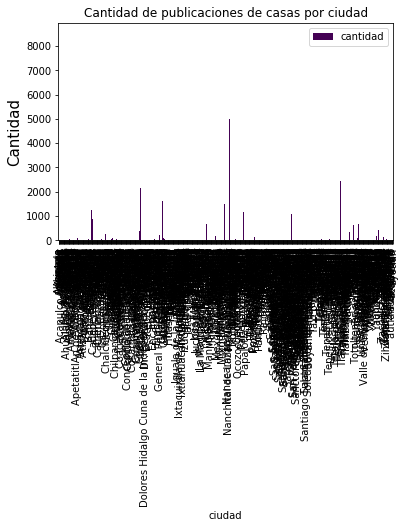

In [15]:
groupCiudadCant.plot.bar(x="ciudad", y="cantidad", rot=90, title = "Cantidad de publicaciones de casas por ciudad",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

**No se entiende nada**, pero parece que hay muchas que tienen **muy pocas publicaciones** y otras bastantes más, voy a ver como las encuentro.

Text(0, 0.5, 'Cantidad')

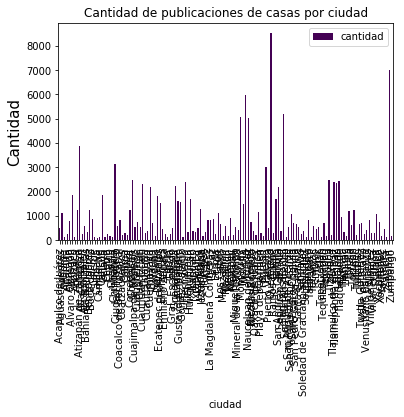

In [16]:
groupCiudadCant.loc[groupCiudadCant["cantidad"] > 100].plot.bar(x="ciudad", y="cantidad", rot=90, title = "Cantidad de publicaciones de casas por ciudad",colormap='viridis').set_ylabel("Cantidad", fontsize=15)

Mejor, pero quiero poder leer los nombres a simple vista, luego veo que hacer con todas las ciudades

Text(0, 0.5, 'Cantidad')

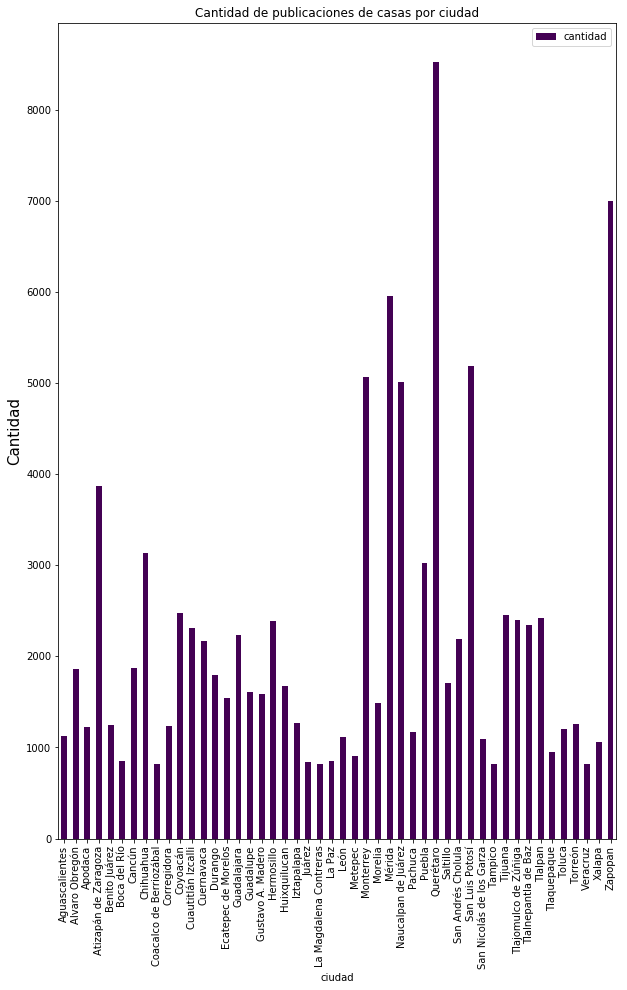

In [17]:
groupCiudadCant.loc[groupCiudadCant["cantidad"] > 800].plot.bar(x="ciudad", y="cantidad", rot=90, title = "Cantidad de publicaciones de casas por ciudad",colormap='viridis', figsize=(10,15)).set_ylabel("Cantidad", fontsize=15)

In [41]:
ciudadPrecioCantidadGroup = casaPrecioCiudad.groupby(casaPrecioCiudad["ciudad"]).agg({"precio": "count"}).reset_index()
ciudadPrecioCantidadGroup.columns = ["ciudad", "cantidad"]
ciudadPrecioCantidadGroup = ciudadPrecioCantidadGroup.loc[groupCiudadCant["cantidad"] > 800]
ciudadPrecioCantidadGroup.head()

,ciudad,cantidad
15,Aguascalientes,1131
27,Alvaro Obregón,1866
43,Apodaca,1221
56,Atizapán de Zaragoza,3876
73,Benito Juárez,1250


In [45]:
CasaPrecioCiudadCantidad = casaPrecioCiudad.merge(ciudadPrecioCantidadGroup, how="right", on = "ciudad")
display(CasaPrecioCiudadCantidad.head())

,ciudad,precio,cantidad
0,San Luis Potosí,488000.00,5192
1,San Luis Potosí,2600000.00,5192
2,San Luis Potosí,2200000.00,5192
3,San Luis Potosí,710000.00,5192
4,San Luis Potosí,3880000.00,5192


Text(0.5, 1.0, 'Precios de casas en distintas ciudades')

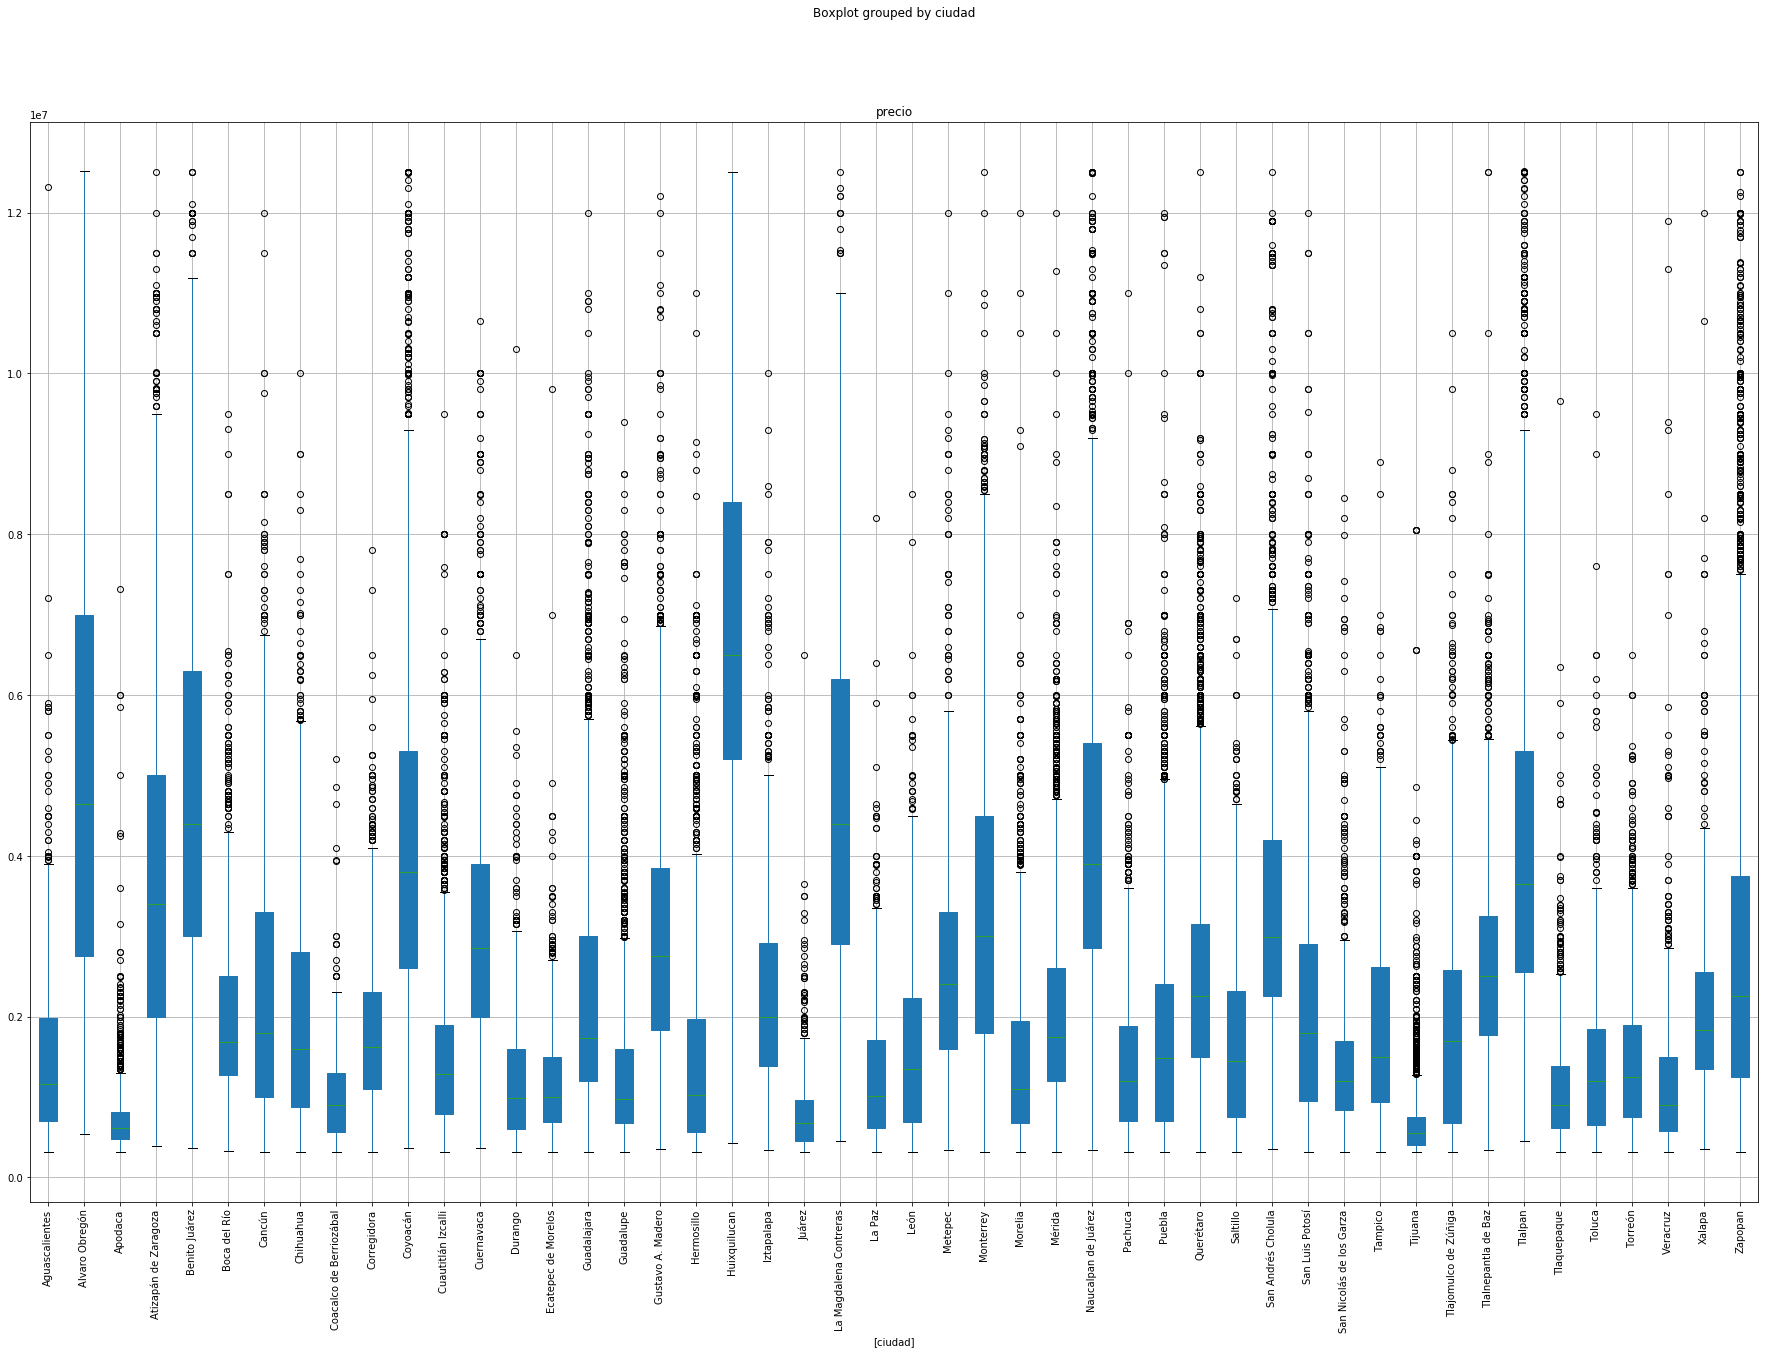

In [49]:
CasaPrecioCiudadCantidadBoxPlot = CasaPrecioCiudadCantidad.boxplot(column=["precio"],rot = 90, patch_artist=True, figsize=(30,20), by=["ciudad"])
casaPrecioCiudadBoxPlot.set_xlabel("Ciudad")
casaPrecioCiudadBoxPlot.set_ylabel("Precio", fontsize=15)
casaPrecioCiudadBoxPlot.set_title("Precios de casas en distintas ciudades", fontsize=15)